This notebook goes through how to draw a **stylized water molecule**.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.cores.post_processing import hard_binarization
from spomso.cores.geom_2d import Circle
from spomso.cores.combine import CombineGeometry

# PARAMETERS

In [2]:
# size of the volume
co_size = 5, 3
# resolution of the volume
co_resolution = 500, 300

show = "FIELD" # BINARY, FIELD
show_midplane = True

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a numpy.ndarray with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Define the **angle** between the *Hydrogen* atoms, **distance** between the *Hydrogen* and *Oxygen* atoms, and the **sizes** of the atoms:

In [4]:
# angle between the H-atoms
angle = 104.5
# distance between the H and O atoms
d = 0.0957
# diameter of the H atom (not realistic!)
h_size = 0.075
# diameter of the O atom (not realistic!)
o_size = h_size*1.3

Define the **smoothing width** for the **smooth union** operation, and which SDFs of the *Hydrogen* and *Oxygen* atoms will be combined:


In [5]:
smoothing_width = 0.45

Calculate the positions of the *Hydrogen* atoms:

In [6]:
x_sep = 10*d*np.cos(np.deg2rad((180-angle)/2))
y_sep = 10*d*np.sin(np.deg2rad((180-angle)/2))

Create the ***Hydrogen*** atom:

In [7]:
h = Circle(10*h_size/2)

**Instance** the ***Hydrogen*** atom twice (**2**) along a line and **position** the atoms:

In [8]:
h.linear_instancing(2, (-x_sep, 0, 0), (x_sep, 0, 0))
h.move((0, -y_sep, 0))

Create the ***Oxygen*** atom:

In [9]:
o = Circle(10*o_size/2)

At this stage the SDFs of atoms will be combined together, but first let's see the possible **combination** operations:

In [10]:
combine = CombineGeometry("")
# see which non-parametric operations are available
operations = combine.available_operations
# see which parametric operations available
parametric_operations = combine.available_parametric_operations

Available non-parametric operations are: ['UNION2', 'UNION', 'SUBTRACT2', 'INTERSECT2', 'INTERSECT']
Available parametric operations are: ['SMOOTH_UNION2_2', 'SMOOTH_UNION2', 'SMOOTH_INTERSECT2', 'SMOOTH_INTERSECT2_BOLTZMAN', 'SMOOTH_SUBTRACT2', 'SMOOTH_SUBTRACT2_BOLTZMAN']


 Set the **operation type** as **SMOOTH_UNION2**, which creates a smooth union of two objects:

In [11]:
combine.operation_type = "SMOOTH_UNION2"

**Combine** the three atoms, with the **smoothing width** defined earlier:

In [12]:
h2o = combine.combine_parametric(h, o, parameters=smoothing_width)

## EVALUATE

Evaluate the SDF of the **water molecule** to create a signed distance field 2D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [13]:
h2o_pattern = h2o.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [14]:
if show_midplane:
    field = smarter_reshape(h2o_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

if show=="BINARY":
    pattern = hard_binarization(h2o_pattern, 0)

# PLOT

Drawing results...
(501, 301)


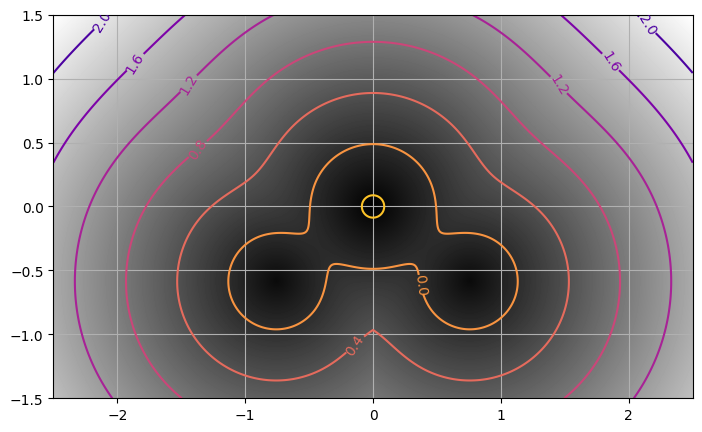

In [15]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[1]/2, co_size[1]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    print(field.shape)
    ax.imshow(field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()